In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !unzip Dataset2C.zip
# %ls

In [6]:
# import shutil

# # Source directory (in Colab)
# source_dir = '/content/Dataset2C'

# # Destination directory in Google Drive
# destination_dir = '/content/drive/MyDrive/Deep Learning'

# # Copy the folder recursively
# shutil.copytree(source_dir, destination_dir)

### Load Data

In [7]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        images.append(img)
    return images

cashew = load_images_from_folder('Dataset2C\cashew')
cempedak = load_images_from_folder("Dataset2C\cempedak")
coconut = load_images_from_folder("Dataset2C\coconut")
cranberry = load_images_from_folder("Dataset2C\cranberry")

### Label Data

In [8]:
def label_classes(features):
    labels = []
    labelcount = 1
    for i in features:
        featurelabels = np.zeros(len(i))
        featurelabels[np.arange(len(i))] = labelcount
        labels = np.append([labels], [featurelabels])
        labelcount += 1
    return labels

labels = label_classes([cashew, cempedak, coconut, cranberry])

### Combine Features

In [9]:
images = []
def combine_features(features):
    images = []
    for i in features:
        for rows in i:
            images.append(np.asarray(rows))
    return images

images = combine_features([cashew, cempedak, coconut, cranberry])

### Color Histograms

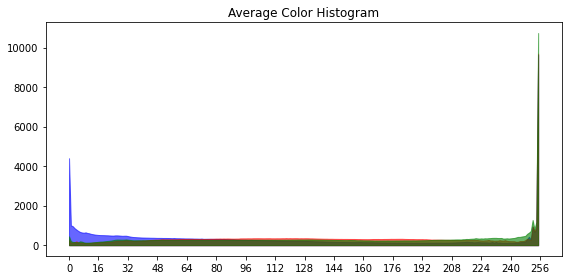

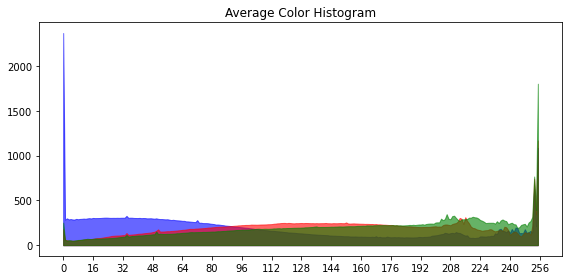

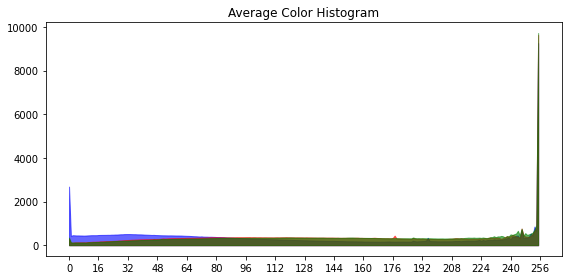

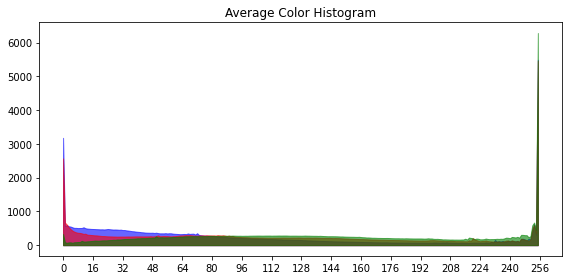

In [10]:
def get_average_histogram_color(features):
    blue = 0
    red = 0
    green = 0
    for i in features:
        blue += cv2.calcHist([i], [0], None, [256], [0, 256]).reshape(-1)
        red += cv2.calcHist([i], [1], None, [256], [0, 256]).reshape(-1)
        green += cv2.calcHist([i], [2], None, [256], [0, 256]).reshape(-1)

    blue = blue / len(features)
    red = red / len(features)
    green = green / len(features)

    plt.figure(figsize=(8, 4))
    plt.title(f"Average Color Histogram")
    plt.fill_between(y1 = blue, x = np.arange(0, len(blue)), color="blue", alpha=0.6)
    plt.fill_between(y1 = red, x = np.arange(0, len(red)), color="red", alpha=0.6)
    plt.fill_between(y1 = green, x = np.arange(0, len(green)), color="green", alpha=0.6)
    plt.xticks(np.arange(0, 257, 16))
    plt.tight_layout()

get_average_histogram_color(cashew)
get_average_histogram_color(cempedak)
get_average_histogram_color(coconut)
get_average_histogram_color(cranberry)

<Figure size 648x432 with 0 Axes>

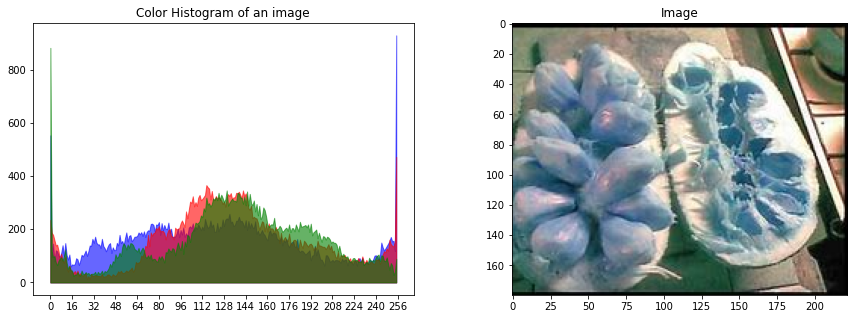

In [11]:
def get_image_color_histogram(image):
    blue = cv2.calcHist([image], [0], None, [256], [0, 256]).reshape(-1)
    red = cv2.calcHist([image], [1], None, [256], [0, 256]).reshape(-1)
    green = cv2.calcHist([image], [2], None, [256], [0, 256]).reshape(-1)
    plt.figure(figsize=(9, 6))
    fig,ax = plt.subplots(ncols=2, nrows=1, figsize = (15, 5))
    ax[0].set_title(f"Color Histogram of an image")
    ax[0].fill_between(y1 = blue, x = np.arange(0, len(blue)), color="blue", alpha=0.6)
    ax[0].fill_between(y1 = red, x = np.arange(0, len(red)), color="red", alpha=0.6)
    ax[0].fill_between(y1 = green, x = np.arange(0, len(green)), color="green", alpha=0.6)
    ax[0].set_xticks(np.arange(0, 257, 16))

    ax[1].imshow(image)
    ax[1].set_title("Image")

get_image_color_histogram(images[500])



In [ ]:
def showimage(image):
    plt.imshow(image)
    plt.show()

### Resize Image

In [33]:
def resize_image(image, new_width = 224, new_height = 224):
    return cv2.resize(image, (new_width, new_height))

for i in range(len(images)):
    images[i] = resize_image(images[i])

### Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size=0.2, random_state=47)
xtest, xval, ytest, yval = train_test_split(xtest, ytest, test_size=0.5, random_state=47)

xtrain = np.array(xtrain, dtype=np.float32)
xtest = np.array(xtest, dtype=np.float32)
xval = np.array(xval, dtype=np.float32)

ytrain = np.array(ytrain, dtype=int)
ytest = np.array(ytest, dtype=int)
yval = np.array(yval, dtype=int)

xtrain = (xtrain/255.0)
xtest = (xtest/255.0)
xval = (xval/255.0)

ytrain = pd.get_dummies(pd.DataFrame(ytrain, columns = ["label"]), columns = ["label"])
ytest = pd.get_dummies(pd.DataFrame(ytest, columns = ["label"]), columns =["label"])
yval = pd.get_dummies(pd.DataFrame(yval, columns = ["label"]), columns =["label"])

### Histogram Equalization

In [ ]:
def histogram_equalization(images):
    equalized_images = []
    for i in range(len(images)):
        img_blue = (cv2.equalizeHist(images[i][:, :, 0]))
        img_green = (cv2.equalizeHist(images[i][:, :, 1]))
        img_red = (cv2.equalizeHist(images[i][:, :, 2]))
        equalized_images.append(np.dstack((img_blue, img_green, img_red)).astype(np.uint8))

    return equalized_images

equalized_images = histogram_equalization(xtrain)
xtest = histogram_equalization(xtest)


Histogram equalization menambahkan kontras image sehingga lebih mudah interpretasi model

<Figure size 648x432 with 0 Axes>

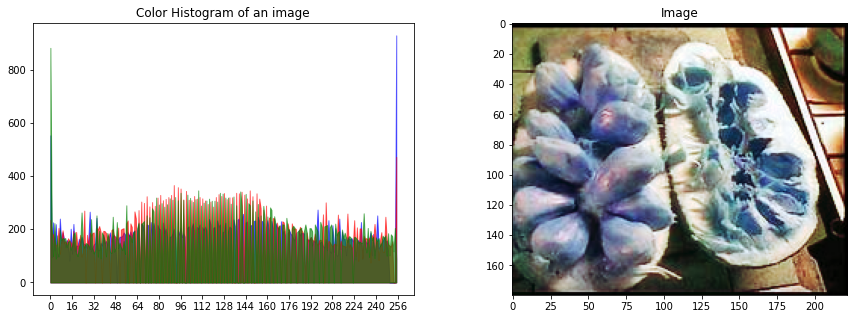

In [13]:
get_image_color_histogram(equalized_images[500])

### Augment Images

In [14]:
import imgaug.augmenters as iaa
np.random.seed(851)
augmentation1 = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-30, 30),
               scale=(0.5, 1.5)),
    iaa.Multiply((0.8, 1.2)),

    iaa.LinearContrast((0.6, 1.4)),

    iaa.Sometimes(0.5,

    iaa.GaussianBlur((0.0, 3.0))
    )
])

np.random.seed(359)
augmentation2 = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-30, 30),
               scale=(0.5, 1.5)),
    iaa.Multiply((0.8, 1.2)),

    iaa.LinearContrast((0.6, 1.4)),

    iaa.Sometimes(0.5,

    iaa.GaussianBlur((0.0, 3.0))
    )
])



In [15]:

def combine(data1, data2):
    images = []
    for i in data1:
      images.append(np.asarray(i))
    for y in data2:
      images.append(np.asarray(y))
    return images



In [16]:
augmented_images = augmentation1(images=equalized_images)
augmented_images = combine(augmented_images, equalized_images)
augmented_images2 = augmentation2(images = equalized_images)
augmented_images = combine(augmented_images, augmented_images2)



In [17]:
augmented_labels = np.append(labels, labels)
augmented_labels = np.append(augmented_labels, labels)

In [18]:
len(augmented_images)

4830

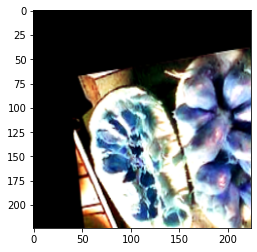

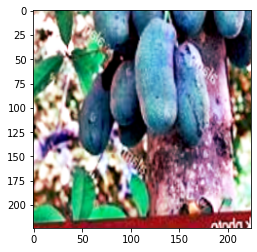

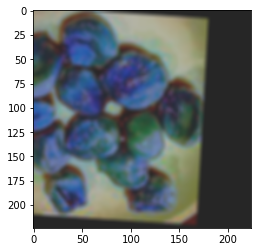

In [23]:
for i in range(3):
    showimage(augmented_images[500+i])

### Tantangan dan Kesulitan

Resolusi: Resolusi data merupakan salah satu kesulitan dari pembuatan model klasifikasi dari dataset ini. Gambar yang kurang detail lebih sulit untuk di pakai model untuk mencari pola.

Noise: Variasi warna dan terang gambar yang tidak dinginkan dapat menjadi masalah karena model dapat melihat noise ini dan mengira ada pola yang penting mengenai sebuah kelas

Image Variability: Varietas gambar dari terang gambar, perspektif dan background yang bervarietas dapat membingungkan model karena subjek yang sama dapat di interpretasikan dengan sangat berbeda dengan varietas-varietas kondisi ini.

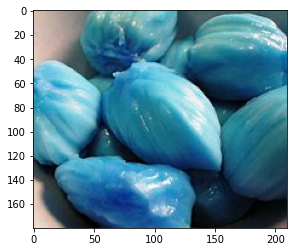

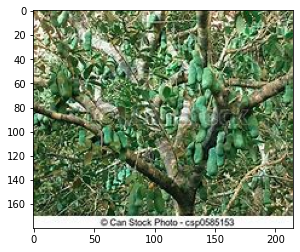

In [25]:
showimage(images[503])
showimage(images[504])

Salah satu contoh masalah image variability adalah dari kedua image ini, dimana cempedak digambar memiliki background, perspektif dan kondisi lighting yang sangat berbeda. Selain itu besar dari cempedak dikedua gambar sangat berbeda.

### VGG - 16 Baseline Model

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import Adam
# from keras.layers import Dropout
# import tensorflow as tf

# from keras.regularizers import l1_l2
# from keras.regularizers import l1
# from keras.regularizers import l2
# from sklearn.metrics import classification_report

In [ ]:
model_VGG = Sequential()

model_VGG.add(Conv2D(64, (3,3), activation="relu", input_shape = (224, 224, 3)))
model_VGG.add(Conv2D(64, (3,3), activation="relu", padding = "same"))
model_VGG.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

model_VGG.add(Conv2D(128, (3,3), activation="relu", padding = "same"))
model_VGG.add(Conv2D(128, (3,3), activation="relu", padding = "same"))
model_VGG.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

model_VGG.add(Conv2D(256,(3,3), activation="relu", padding = "same"))
model_VGG.add(Conv2D(256, (3,3), activation="relu", padding = "same"))
model_VGG.add(Conv2D(256, (3,3), activation="relu", padding = "same"))
model_VGG.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

model_VGG.add(Conv2D(512, (3,3), activation="relu", padding = "same"))
model_VGG.add(Conv2D(512, (3,3), activation="relu", padding = "same"))
model_VGG.add(Conv2D(512, (3,3), activation="relu", padding = "same"))
model_VGG.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

model_VGG.add(Conv2D(512, (3,3), activation="relu", padding = "same"))
model_VGG.add(Conv2D(512, (3,3), activation="relu", padding = "same"))
model_VGG.add(Conv2D(512, (3,3), activation="relu", padding = "same"))
model_VGG.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

model_VGG.add(Flatten())

model_VGG.add(Dense(4096, activation="relu"))
model_VGG.add(Dense(4096, activation="relu"))
model_VGG.add(Dense(4, activation="softmax"))

model_VGG.compile(loss = "categorical_crossentropy", optimizer = SGD(learning_rate = 0.01), metrics = ["categorical_accuracy"])


In [ ]:
# model_VGG.fit(xtrain, ytrain, epochs=5,  validation_data= (xval, yval))


In [ ]:
# model_VGG.save("45epochs_VGG+.h5")

In [ ]:
# !cp '/content/45epochs_VGG+.h5' '/content/drive/My Drive/ProblemB_Models/'


In [21]:
from tensorflow.keras.models import load_model
VGGplus_45epoch = load_model('/content/drive/My Drive/Copy of 45epochs_VGG+.h5')

In [22]:

predictions = VGGplus_45epoch.predict(xtest)
pred_labels = np.argmax(predictions, axis = 1)
print(classification_report(np.argmax(ytest, axis=1), pred_labels))

16/16 [==============================] - 11s 224ms/step
              precision    recall  f1-score   support

           0       0.64      0.36      0.46       121
           1       0.55      0.76      0.64       113
           2       0.58      0.64      0.61       125
           3       0.86      0.85      0.85       124

    accuracy                           0.65       483
   macro avg       0.66      0.65      0.64       483
weighted avg       0.66      0.65      0.64       483



In [ ]:
# VGGplus_40epoch.fit(xtrain, ytrain, epochs=5,  validation_data= (xval, yval))

Epoch 1/5
121/121 [==============================] - 107s 670ms/step - loss: 0.7164 - categorical_accuracy: 0.6938 - val_loss: 0.8332 - val_categorical_accuracy: 0.6480
Epoch 2/5
121/121 [==============================] - 61s 508ms/step - loss: 0.6972 - categorical_accuracy: 0.7081 - val_loss: 0.9016 - val_categorical_accuracy: 0.6190
Epoch 3/5
121/121 [==============================] - 61s 508ms/step - loss: 0.6427 - categorical_accuracy: 0.7404 - val_loss: 0.9217 - val_categorical_accuracy: 0.6356
Epoch 4/5
121/121 [==============================] - 61s 506ms/step - loss: 0.6207 - categorical_accuracy: 0.7422 - val_loss: 1.2305 - val_categorical_accuracy: 0.5362
Epoch 5/5
121/121 [==============================] - 61s 508ms/step - loss: 0.6282 - categorical_accuracy: 0.7472 - val_loss: 0.9597 - val_categorical_accuracy: 0.6232


In [16]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.initializers import HeNormal
from keras.regularizers import l1_l2



In [16]:
model_modified = Sequential()


model_modified.add(Conv2D(64, (3,3), padding = "same", kernel_initializer=HeNormal()))
model_modified.add(BatchNormalization())
model_modified.add(Activation('relu'))
model_modified.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))


model_modified.add(Conv2D(128, (3,3), padding = "same", kernel_initializer=HeNormal()))
model_modified.add(BatchNormalization())
model_modified.add(Activation('relu'))
model_modified.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))


model_modified.add(Conv2D(256, (3,3), padding = "same", kernel_initializer=HeNormal()))
model_modified.add(BatchNormalization())
model_modified.add(Activation('relu'))
model_modified.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

model_modified.add(Conv2D(512, (3,3), padding = "same", kernel_initializer=HeNormal()))
model_modified.add(BatchNormalization())
model_modified.add(Activation('relu'))
model_modified.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))


model_modified.add(Conv2D(512, (3,3), padding = "same", kernel_initializer=HeNormal()))
model_modified.add(BatchNormalization())
model_modified.add(Activation('relu'))
model_modified.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

model_modified.add(Flatten())
model_modified.add(Dropout(0.5))
model_modified.add(Dense(4096, activation="relu", kernel_initializer=HeNormal()))
model_modified.add(Dropout(0.5))
model_modified.add(Dense(4096, activation="relu", kernel_initializer=HeNormal(),kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model_modified.add(Dense(4, activation="softmax"))

model_modified.compile(loss = "categorical_crossentropy", optimizer = SGD(learning_rate = 0.01), metrics = ["categorical_accuracy"])

In [17]:
model_modified.fit(xtrain, ytrain, epochs=30,  validation_data= (xval, yval))

Epoch 1/30
121/121 [==============================] - 45s 267ms/step - loss: 304.7909 - categorical_accuracy: 0.3577 - val_loss: 292.7732 - val_categorical_accuracy: 0.3416
Epoch 2/30
121/121 [==============================] - 25s 208ms/step - loss: 282.3978 - categorical_accuracy: 0.5028 - val_loss: 272.1054 - val_categorical_accuracy: 0.5238
Epoch 3/30
121/121 [==============================] - 25s 211ms/step - loss: 262.2795 - categorical_accuracy: 0.5644 - val_loss: 252.4639 - val_categorical_accuracy: 0.5549
Epoch 4/30
121/121 [==============================] - 25s 207ms/step - loss: 243.1502 - categorical_accuracy: 0.6017 - val_loss: 234.1547 - val_categorical_accuracy: 0.5114
Epoch 5/30
121/121 [==============================] - 25s 208ms/step - loss: 224.9357 - categorical_accuracy: 0.6227 - val_loss: 216.1216 - val_categorical_accuracy: 0.6004
Epoch 6/30
121/121 [==============================] - 25s 210ms/step - loss: 207.6083 - categorical_accuracy: 0.6550 - val_loss: 199.24

In [18]:
model_modified.save("30epochs_moodified_l1l2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
!cp '/content/30epochs_moodified_l1l2.h5' '/content/drive/My Drive/Deep learning/'


In [20]:
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore")

predictions = model_modified.predict(xtest)
pred_labels = np.argmax(predictions, axis = 1)
print(classification_report(np.argmax(ytest, axis=1), pred_labels))

16/16 [==============================] - 1s 57ms/step
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       121
           1       0.76      0.82      0.79       113
           2       0.74      0.67      0.71       125
           3       0.96      0.77      0.86       124

    accuracy                           0.77       483
   macro avg       0.78      0.77      0.77       483
weighted avg       0.78      0.77      0.77       483



### Setelah melakukan tuning hyperparameter berupa jumlah cnn dan dense layers, saya menemukan bahwa model yang lebih kecil menghasilkan performa yang lebih baik dibandingkan base model VGG-16 yang diberikan. Selain itu, untuk mengurangi overfitting, saya menambahkan dropout layer dan l1, l2 regulizer. Batch Normalization juga ditambahkan untuk mempercepat convergence dan juga sebagai regulizer tambahan. Untuk setiap convolutional layer diberi weight initialization menggunakan He initializer yang merupakan initializer yang dedesain untuk bekerja dengan baik jika dipakai di layer Relu. Alasan mengapa perubahan arsitektur ini membantu dalam berbagai tantangan yang disebutkan diatas, salah satunya adalah perbedaan yang jauh berbeda antara setting setiap gambar dalam satu kategori seperti background, lighting, persepective, dll. Menggunakan dropout dan l1, l2 regulizer mengurangi overfitting model yang mungkin belajar terlalu banyak dari gambar yang tidak terlalu baik untuk di generalisasi (contohnya gambar cempedak yang 90% imagenya adalah background). Untuk besar modelnya, sepertinya jumlah training data di dataset ini kurang banyak untuk mempergunakan model VGG-16 yang sangat besar sehingga performa model yang dikecilkan lebih tinggi.